In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import numpy as np
import torch
import torch.nn as nn
from problems import GraphProblem
from policies import RandomPolicy, GreedyPolicy
from planning import WaypointPlanner
from learning import learning_epoch, initialize_with_mds
from collections import deque

In [123]:
import networkx as nx
import copy

In [124]:
# Hyperparameters
n = 100  # number of vertices
p = 0.05  # edge probability
gamma = 0.99  # discount factor
k = 100    # latent dimension
N_T = 50  # number of parallel trajectories/planners
num_epochs = 500
num_iters = 10
learn_frequency = 10  # learn every N epochs
learning_rate = 0.001
batch_size = 6400  # batch size for learning
buffer_size = 10000  # replay buffer size

In [ ]:
temp = 1.0
l2_reg = 0
c = 1.0
max_waypoints = 0

infonce=False

In [157]:
# Initialize environment
env = GraphProblem(n, p, seed=42)

In [158]:
psi =initialize_with_mds(env, k, gamma=gamma)

/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [159]:
# Initialize learnable parameters
psi_torch = nn.Parameter(torch.tensor(psi, dtype=torch.float32, requires_grad=True))
A_torch = nn.Parameter(torch.eye(k, requires_grad=True))  # Initialize A to identity

# Initialize policy (random at first)
def psi_fun(x: int) -> np.ndarray:
    return psi_torch.detach().numpy()[x, :]

policy = RandomPolicy(env, seed=42)

In [160]:
# Create N_T waypoint planners with random start/goal
planners = []
for i in range(N_T):
    start = np.random.randint(0, n)
    goal = np.random.randint(0, n)
    while goal == start:
        goal = np.random.randint(0, n)
    
    planner = WaypointPlanner(
        start=start,
        goal=goal,
        env=copy.deepcopy(env),  # Each planner gets its own env copy
        policy=policy,
        psi=psi_fun,
        A=A_torch.detach().numpy(),
        waypoint_type='c',  # Use interpolative waypoints
        max_waypoints=max_waypoints,
        c=c,
        T=temp
    )
    planners.append(planner)

print(f"Created {len(planners)} planners")

Created 50 planners


In [161]:
# Initialize replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Training loop
losses = []

# Training loop with geometric future state sampling
for epoch in range(num_epochs):
    # Step each planner forward and collect (current_state, future_state) pairs
    for i, planner in enumerate(planners):
        # Step planner
        action, waypoint, done = planner.step()
        
        # Sample (current_state, future_state) pair from trajectory
        if len(planner.trajectory) >= 2:
            # Randomly sample a position in the trajectory (not the last one)
            current_idx = np.random.randint(0, len(planner.trajectory) - 1)
            # current_idx = len(planner.trajectory) - 2
            current_state = planner.trajectory[current_idx]
            
            # Sample future state from trajectory using geometric distribution
            future_state = planner.sample_future_state(current_idx, p=gamma)
            # future_state = planner.trajectory[current_idx+1]
            
            if future_state is not None:
                # Store (current_state, future_state) pair
                replay_buffer.append((current_state, future_state))
        

        # Reset if done
        if done:
            start = np.random.randint(0, n)
            goal = np.random.randint(0, n)
            while goal == start:
                goal = np.random.randint(0, n)
            planner.reset(start, goal)
    
    # Learning step
    if epoch > 0 and epoch % learn_frequency == 0 and len(replay_buffer) >= batch_size:
        # Sample batch
        indices = np.random.choice(len(replay_buffer), size=batch_size, replace=False)
        batch = [replay_buffer[i] for i in indices]
        
        # Extract current and future states
        current_states = [s for s, _ in batch]
        future_states = [s_plus for _, s_plus in batch]
        
        # Run learning
        psi_torch, A_torch, policy, loss_val = learning_epoch(
            psi_torch, A_torch, current_states, future_states, env,
            learning_rate=learning_rate, iters_per_epoch=num_iters, policy_temperature=temp,
            l2_reg=l2_reg, use_infonce=False
        )
        
        # Update planners
        psi_np = psi_torch.detach().numpy()
        A_np = A_torch.detach().numpy()
        
        for planner in planners:
            planner.policy = policy
            planner.psi = lambda x: psi_np[x, :]
            planner.A = A_np
        
        losses.append(loss_val)

        print(f"Epoch {epoch}: Buffer size = {len(replay_buffer)}, "
                  f"Learning updates performed")
        print(f"Current loss: {losses[-1]}")
    

print("Training complete!")
        

Epoch 130: Buffer size = 6550, Learning updates performed
Current loss: 0.8028263449668884
Epoch 140: Buffer size = 7050, Learning updates performed
Current loss: 0.7938617467880249
Epoch 150: Buffer size = 7550, Learning updates performed
Current loss: 0.7854799628257751
Epoch 160: Buffer size = 8050, Learning updates performed
Current loss: 0.7777162790298462
Epoch 170: Buffer size = 8550, Learning updates performed
Current loss: 0.7708320021629333
Epoch 180: Buffer size = 9050, Learning updates performed
Current loss: 0.764093816280365
Epoch 190: Buffer size = 9550, Learning updates performed
Current loss: 0.7584726810455322
Epoch 200: Buffer size = 10000, Learning updates performed
Current loss: 0.7531219124794006
Epoch 210: Buffer size = 10000, Learning updates performed
Current loss: 0.7479767203330994
Epoch 220: Buffer size = 10000, Learning updates performed
Current loss: 0.7435706853866577
Epoch 230: Buffer size = 10000, Learning updates performed
Current loss: 0.7393944859504

In [162]:
# # Initialize replay buffer
# replay_buffer = deque(maxlen=buffer_size)

# # Training loop
# losses = []

# for epoch in range(num_epochs):
#     # Step each planner forward and collect (state, action, waypoint)
#     for planner in planners:
#         action, waypoint, done = planner.step()
        
#         if action is not None and waypoint is not None:
#             # Store (action, waypoint) in replay buffer
#             replay_buffer.append((action, waypoint))
        
#         # If planner is done, reset with new random start/goal
#         if done:
#             start = np.random.randint(0, n)
#             goal = np.random.randint(0, n)
#             while goal == start:
#                 goal = np.random.randint(0, n)
#             planner.reset(start, goal)
    
#     # Learning step (every learn_frequency epochs)
#     if epoch > 0 and epoch % learn_frequency == 0 and len(replay_buffer) >= batch_size:
#         # Sample random batch from replay buffer
#         indices = np.random.choice(len(replay_buffer), size=batch_size, replace=False)
#         batch = [replay_buffer[i] for i in indices]
        
#         # Extract actions and waypoints
#         actions = [action for action, waypoint in batch]
#         waypoints = torch.tensor([waypoint for action, waypoint in batch], dtype=torch.float32)
        
#         # Run learning epoch
#         psi_torch, A_torch, policy, loss = learning_epoch(
#             psi_torch, A_torch, actions, waypoints, env,
#             learning_rate=learning_rate,
#             iters_per_epoch=1,
#             T=temp
#         )
        
#         # Update psi_fun and all planners with new policy, psi, A
#         def psi_fun(x: int) -> np.ndarray:
#             return psi_torch.detach().numpy()[x, :]
        
#         A_np = A_torch.detach().numpy()
        
#         for planner in planners:
#             planner.policy = policy
#             planner.psi = psi_fun
#             planner.A = A_np
        
#         losses.append(loss)  # Track loss
        
#         print(f"Epoch {epoch}: Buffer size = {len(replay_buffer)}, "
#                   f"Learning updates performed")
#         print(f"Current loss: {losses[-1]}")
    

# print("Training complete!")

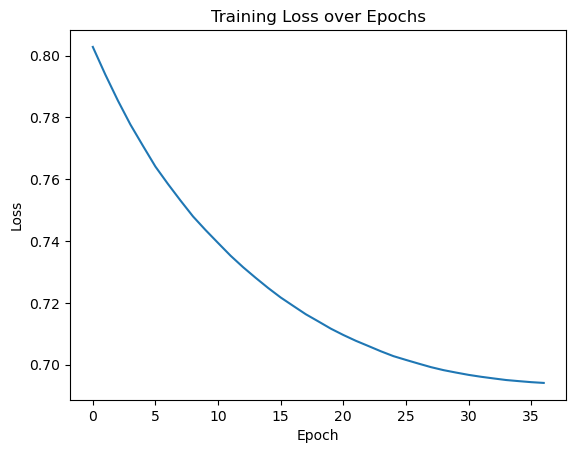

In [163]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [164]:
def f_encoder(x: int) -> np.ndarray:
    return psi_fun(x)

def s_encoder(x: int) -> np.ndarray:
    return A_torch.detach().numpy() @ f_encoder(x)

In [165]:
test_policy = GreedyPolicy(copy.deepcopy(env), 
                           s_encoder=s_encoder, 
                           temperature=0.01*temp)

In [166]:
A_torch

Parameter containing:
tensor([[ 0.6313, -0.3340,  0.2635,  0.3188,  0.3480,  0.0567,  0.3250,  0.3699,
          0.0736],
        [-0.3340,  0.6314, -0.3684,  0.1470, -0.2250,  0.0952, -0.2452, -0.2740,
         -0.1244],
        [ 0.2695, -0.3684,  0.6314, -0.1199, -0.0616, -0.2113, -0.1274,  0.2767,
          0.3688],
        [ 0.3120,  0.1624, -0.1251,  0.6313,  0.3122,  0.3638,  0.3223,  0.3449,
         -0.2963],
        [ 0.3469, -0.2363, -0.0559,  0.3126,  0.6312,  0.1148,  0.3650,  0.3309,
         -0.2851],
        [ 0.0524,  0.0907, -0.2002,  0.3589,  0.1141,  0.6312,  0.3689,  0.2617,
         -0.3692],
        [ 0.3248, -0.2723, -0.1158,  0.3180,  0.3676,  0.3687,  0.6313,  0.2873,
         -0.3335],
        [ 0.3699, -0.2813,  0.2820,  0.3459,  0.3301,  0.2569,  0.2871,  0.6313,
         -0.1836],
        [ 0.0705, -0.1013,  0.3523, -0.2947, -0.2896, -0.3693, -0.3342, -0.1985,
          0.6312]], requires_grad=True)

In [173]:
test_policy.get_action(15, f_encoder(50), debug=True)

State: 15, Available actions: [20, 39, 64, 70]
Distances: [ 0.00053768 -0.10870097  0.01338821  0.17537281]
Logits: [ -0.05376849  10.870097    -1.3388212  -17.537281  ]
Probabilities: [1.8022523e-05 9.9997699e-01 4.9856762e-06 4.6006802e-13]
Selected action: 39


np.int64(39)

In [170]:
nx.shortest_path(env.graph, source=15, target=50)

[15, 64, 10, 19, 50]

In [153]:
# Test the learned policy on many start/goal pairs
num_test_pairs = 10
success_count = 0
lens = []
true_lens = []

test_policy = policy

for _ in range(num_test_pairs):
    start = np.random.randint(0, n)
    goal = np.random.randint(0, n)
    while goal == start:
        goal = np.random.randint(0, n)

    true_lens.append(len(nx.shortest_path(env.graph, source=start, target=goal)))
    
    arr = []
    for k in range(10):

        
        test_trajectory = [start]
        max_test_steps = 100
        
        for _ in range(max_test_steps):
            action = test_policy.get_action(test_trajectory[-1], f_encoder(goal))
            # print(action)
            if action is not None:
                test_trajectory.append(action)
            if action == goal:
                break
        
        reached_goal = test_trajectory[-1] == goal
        success_count += int(reached_goal)
        arr.append(len(test_trajectory))
    
    lens.append(arr)
        

In [154]:
print(true_lens)

[4, 3, 3, 3, 2, 5, 5, 5, 3, 5]


In [155]:
print([sum(l)/len(l) for l in lens])

[6.6, 4.6, 4.1, 3.4, 2.2, 5.5, 7.1, 6.9, 5.5, 6.0]


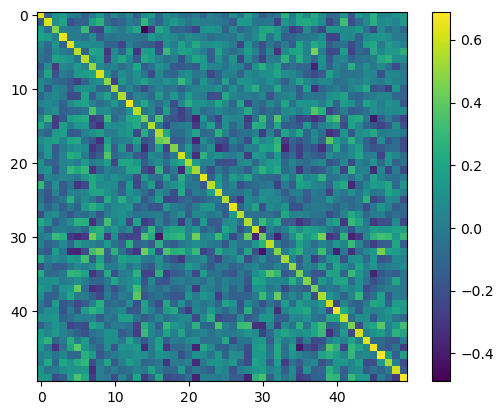

In [210]:
# heatmap of A
import matplotlib.pyplot as plt
plt.imshow(A_torch.detach().numpy(), cmap='viridis')
plt.colorbar()

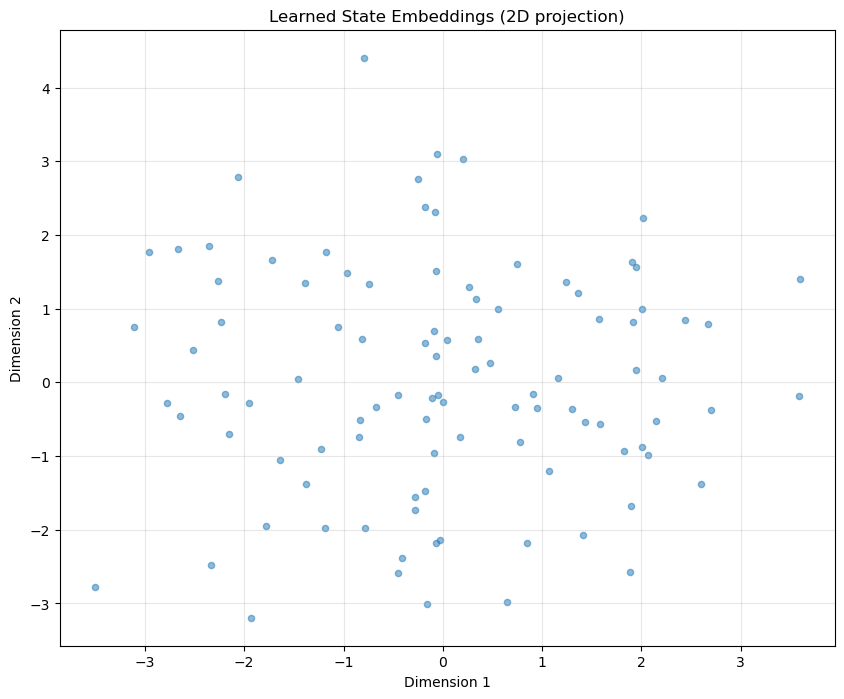

In [212]:
# Visualize learned embeddings (optional - requires matplotlib)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get all embeddings
psi_np = psi_torch.detach().numpy()

# Reduce to 2D for visualization
if k > 2:
    pca = PCA(n_components=2)
    psi_2d = pca.fit_transform(psi_np)
else:
    psi_2d = psi_np[:, :2]

plt.figure(figsize=(10, 8))
plt.scatter(psi_2d[:, 0], psi_2d[:, 1], alpha=0.5, s=20)
plt.title('Learned State Embeddings (2D projection)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()